# Crossvalidation and Nested crossvalidation

The goal of all models we build is to **predict** and **generalize**.
If our model only works for the data we train it on, and doesn't work for anything else, it's not a very useful model.

One way to test generalization is to split the data into training and testing data.
The training data is used to estimate the model's parameters, and the testing data is used to determine how much we can trust the model's predictions on unseen data.
If the performance of the model is very good on the training data but very poor on the testing data, we say that the model has **overfit** the training data.
If the model's performance on the testing data is as good or better than the training data, then we conclude that the model will generalize well.

But what if we're wrong?
What if we got lucky with a train/test split, such that the testing data is "easy" and very similar to the training data?
One way to increase our confidence is to train and test **repeatedly with different train/test splits**.
But again, we have a problem: what if our train/test splits overlap substantially?
We only get more information about model performance if the splits are different, not when they are the same.

## Crossvalidation

**Crossvalidation** is a fairly simple yet elegant idea that solves these problems.
Crossvalidation lets us use **all** our data for both training and testing, by partitioning it in separate sets, typically called **folds**. 

Figure 1 shows all the data split into 5 folds.
Crossvalidation training would create five models using these five folds, such that each model uses a different fold for testing (blue).
All the other folds are used for training.
For example, one model would use fold 1 for testing and folds 2-5 for training.

<!-- 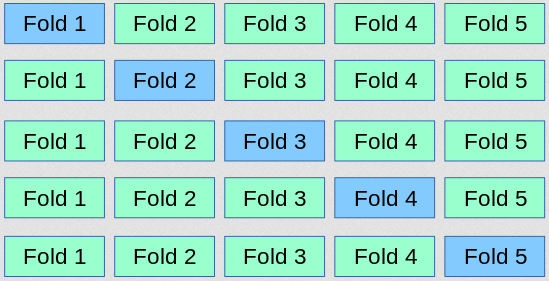 -->
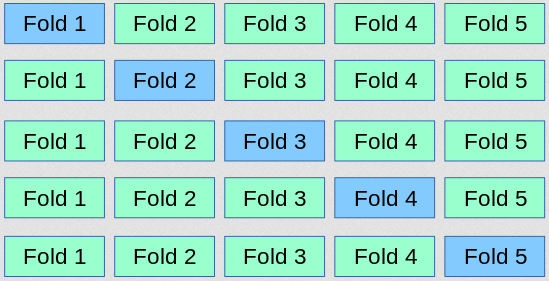
<center><b>Figure 1. Crossvalidation with five folds.</b> Source: <a href="https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation">Adapted from scikit-learn</a></center>

Using crossvalidation, all data is used for both training and testing **but not at the same time.**
This allows us to train with all the data without worrying about overfitting. 
It also lets us robustly test generalization because we've used all the data for testing as well.

Crossvalidation works nicely with all of the standard peformance metrics like $r^2$, accuracy, and precision/recall: because the predictions from separate models are on separate folds, we can calculate performace metrics as though the predictions came from a single model.
Alternatively, we can calculate performance on each fold separately to get a distribution of performance.

Finally, you might see the connections between crossvalidation and out-of-bag (OOB) error with bagging.
Crossvalidation could be viewed as a generalization of OOB, since crossvalidation can be used with any model.
Crossvalidation is also a simplification over OOB, since OOB requires keeping track of which aggregated models are "allowed" to make a prediction on a datapoint, whereas in crossvalidation a single model makes predictions on its test fold, and that's it.

## Example: Crossvalidation

Let's take a look at the `iris` dataset, which consists of measurements of sepals and petals, as well as the class label for three species of iris.

| Variable                 | Type    | Description                                                                    |                                |
|:--------------------------|:---------|:--------------------------------------------------------------------------------|--------------------------------|
| Sepal Length             | Ratio   | Length of the leaves that suppor the petals                                    |                                |
| Sepal Width              | Ratio   | Width of the leaves that suppor the petals                                     |                                |
| Petal Length             | Ratio   | Length of petals                                                               |                                |
| Petal Width              | Ratio   | Width of petals                                                                |                                |
| Species                  | Nominal                                                                        | Setosa, Versicolour, Virginica |                               

Because this is a familiar dataset, and because the focus is on crossvalidation, we will skip data exploration steps and go quickly to modeling.

### Load data

Import `pandas` so we can load a dataframe:

- `import pandas as pd`

Load the dataframe:

- Create `dataframe` and set it to `with pd do read_csv using` a list containing
    - `"datasets/nursery.csv"`
- `dataframe`

### Prepare train/test sets

Let's separate our predictors (`X`) from our class label (`Y`), putting each into its own dataframe:

- Create `X` and set to `with dataframe do drop using` a list containing
    - freestyle `columns=["Species"]`
- Create `Y` and set to `dataframe [ ]` containing a list with `"Species"` inside

### Train model with crossvalidation

We need libraries for Gaussian naive Bayes, crossvalidation, and `ravel`

- `import sklearn.model_selection as model_selection`
- `import sklearn.naive_bayes as naive_bayes`
- `import numpy as np`

There are several different options for crossvalidation output.
The most straightforward is probably `cross_val_predict`, which takes a model, data, and specifications for crossvalidation, and then trains the model and makes predictions on the test folds:

- Create variable `predictions`
- Set it to `with model_selection do cross_val_predict using` a list containing
    - `with naive_bayes create GaussianNB using`
    - `X`
    - `with np do ravel using` a list containing `Y`
    - freestyle `cv=10` (for 10 folds)
    
**Note:** we can also use a pipeline instead of a vanilla model if we need to scale variables, etc.

Notice how much simpler this is that creating train/test splits!

### Evaluate the model

To measure performance, we need `sklearn.metrics`:

- `import sklearn.metrics as metrics`

We can get the accuracy by comparing the predictions to *all* of `Y`:

- `with metrics do accuracy_score using` a list containing
    - `Y`
    - `predictions`

And similarly we can get the recall and precision using all of `Y`:

- `print with metrics do classification_report using` a list containing
    - `Y`
    - `predictions`
    

Because we split the data 10 different ways and trained 10 different models, we can be reasonably confident that we will see similar performance on new data.

There are [other crossvalidation methods](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) besides `cross_val_predict` that return metrics per fold if you would like to see the range of performance across folds.

## Nested crossvalidation

Not only can crossvalidation help us better estimate model generalization, but it can also help us find **hyperparameters** of our models.
A hyperparameter is something you specify when you create the model, as opposed to a parameter the model learns.
Common examples we've encountered are the value for `K` in KNN, regularization parameters in ridge regression and lasso regression, and the `C` parameter for margin softness in SVM.
Crossvalidation works for hyperparameters because the problem we face with them is much the same as with model fit: we can choose a hyperparameter that works well for some data, but it might not work well on other data.
So if we use crossvalidation, we can get a good idea of how well a particular value for a hyperparameter works across the dataset.

However, for hyperparameter crossvalidation to be really powerful, we need to to explore multiple candidate values for the hyperparameter, and then use crossvalidation for each one.
**Grid search** is a simple way of defining candidate values for hyperparameters.
Simply stated, vanilla grid search takes a list of candidate hyperparameter values you define and creates a separate model to evaluate each of those hyperparameter values.

Grid search and crossvalidation work together like this:

- Grid search gives crossvalidation a hyperparameter value
- Crossvalidation builds as many models using that hyperparameter as there are folds
- The average performance across folds is used to score the hyperparameter
- Grid search gives crossvalidation another hyperparameter value and the process repeats
- Once all hyperparameter values have been scored, the best is returned by grid search

While grid search and crossvalidation are very powerful together, they potentially create another problem for us.
As we've discussed, we don't want to train and test with the same data, because then we don't know for sure our model will generalize.
The problem is that if we do grid search to find hyperparameters on the same data we test our model on, then we've trained and tested with the same data.
We could solve this problem by spliting our data into two sets, one for hyperparameter search + model training, and one for testing.
However, that approach takes us back to the train/test split problem - what if we get a lucky split?We already solved the train/test split problem with crossvalidation, so can we solve this problem using crossvalidation too?

The answer is yes, we can solve train/test splits for hyperparameters and normal model training at the same time using **nested crossvalidation**.
Simply stated, nested crossvalidation partitions the data into folds and then partitions each of those folds into folds.
The first set of folds (the **outer folds**) are used to train the model in the way we discussed in the last section.
The second set of folds are used to evaluate the hyperparameters, e.g. using grid search.
The reason that nested crossvalidation works is that when the model is tested on a fold, it hasn't used that fold to estimate its hyperparameters or its parameters.

## Example: Nested crossvalidation

Let's continue our example with the `iris` dataset, but switch models to `SVC` with has the hyperparameter `C`.

### Train model with nested crossvalidation

We need to import libraries for:

- SVM
- Scale (SVM is very sensitive to standardization)
- Pipeline (to combine scaling and modeling)

So we need the following imports:

- `import sklearn.svm as svm`
- `import sklearn.preprocessing as pp`
- `import sklearn.pipeline as pipe`

We're going to make a pipeline so we can scale and train in one step.
However, we need to **name the stages** in order for grid search to work:

- Create variable `model`
- Set it to `with pipe create Pipeline using` a list containing a list containing
    - a tuple (from LISTS; see picture below) containing
        - `"scale"`
        - `with pp create StandardScaler using`
    - a tuple containing
        - `"svm"`
        - `with svm create SVC using` a list containing
            - freestyle `random_state=1`
            - freestyle `kernel="rbf"` (for a radial basis function kernel)

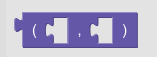

This is our base model that we need to give to grid search, along with a parameter values we want grid search to try for `C`.
Let's try the list `[1, 10, 100]`!

- Create variable `gridSearch`
- Set it to `with model_selection create GridSearchCV using` a list containing
    - freestyle `estimator=` followed by `model`
    - freestyle `param_grid={'svm__C': [1, 10, 100]`}`
    - freestyle `cv=10` (10 inner folds for grid search)


- Set `predictions` to `with model_selection do cross_val_predict using` a list containing
    - `gridSearch`
    - `X`
    - `with np do ravel using` a list containing `Y`
    - freestyle `cv=10` (10 outer folds for model parameters)

### Evaluate the model

We can get the accuracy by comparing the predictions to *all* of `Y`:

- `with metrics do accuracy_score using` a list containing
    - `Y`
    - `predictions`

And similarly we can get the recall and precision using all of `Y`:

- `print with metrics do classification_report using` a list containing
    - `Y`
    - `predictions`
    

In this case, likely because the classification problem is so easy, there is no improvement between Gaussian naive Bayes and our hyperparameter-tuned SVM.

### Hyperparameter

Interestingly, the nested crossvalidation approach in `sklearn` does not return the best hyperparameter values found.
The simplest option is to discover the hyperparameter values using all the data, but then only report the performance using nested crossvalidation above.
Alternatively, one could write custom code to calculate the optimal hyperparameter values for each fold.
To do the simple option:

- `with gridSearch do fit` using a list containing
    - `X`
    - `with np do ravel using` a list containing `Y`

Now the best hyperparameter values can be displayed:
    
- freestyle `gridSearch.best_params_`

We can see that `1` is the best parameter for `C`.
One strategy to improve on this might be to grid search using values closer to 1.

## Submit your work

When you have finished the notebook, please download it, log in to [OKpy](https://okpy.org/) using "Student Login", and submit it there.

Then let your instructor know on Slack.
